# Ecercise 1
Berkay Günes 

## 1 Exploring the Data

In [1]:
from sklearn.datasets import load_digits
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

In [2]:
digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

Text(0.5, 1.0, "Interpolation methode 'nearest'")

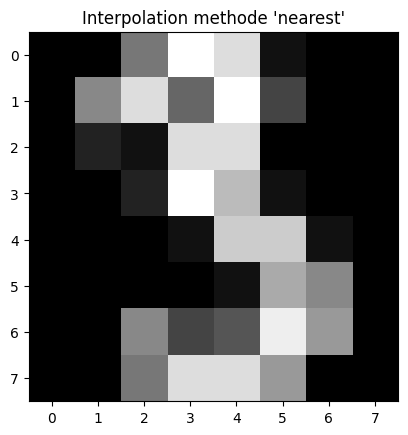

In [3]:
img = images[3]
assert 2 == len(img.shape)
plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest")
plt.title("Interpolation methode 'nearest'")

Text(0.5, 1.0, "Interpolation methode 'bicubic'")

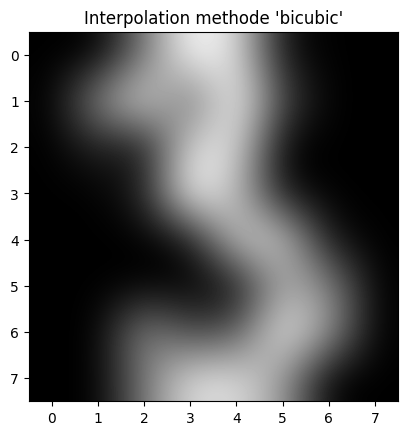

In [4]:
plt.imshow(img, interpolation="bicubic")
plt.title("Interpolation methode 'bicubic'")

In [5]:
mask = np.logical_or(target == 3,target == 9)

X_all = data[mask]
y_all = target[mask]

X_train , X_test , y_train , y_test =\
    model_selection.train_test_split(X_all, y_all, test_size = 0.4, random_state = 0)

## 2 Hand-crafted classifier
### 2.1 Feature construction
To determine the important pixels for a classification we first look at the difference between the average 3's and 9's. 

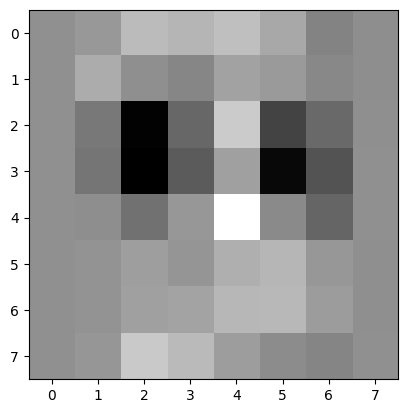

In [6]:
av3 = sum(images[target == 3]) / len(images[target == 3])
av9 = sum(images[target == 9]) / len(images[target == 9])

diff39 = (av3-av9)
plt.imshow(diff39, interpolation='nearest')

This image shows us in which pixels the difference is biggest between the 3's and 9's. <br>
The four pixels to focus on are (2,2), (2,3), (4,4) and (5,3), but not all four pixels are equaly important. 

In [7]:
def features2d(x):
    pc = np.zeros((len(x), 2))
    
    for i in range(0, len(x)):
        pc[i, 0] = 8.8 * x[i, 8*2+2] + 9 * x[i, 8*3+2] + 8.5 * x[i, 8*3+5] + 4.8 * x[i, 8*2+5]
        pc[i, 1] = 7 * x[i, 8*4+4] + 3.7 * x[i, 8*2+4] + 3.6 * x[i, 8*7+2]
        
    return pc

In [8]:
features = features2d(X_all)

### 2.2 Scatterplot

Text(0, 0.5, 'PC2')

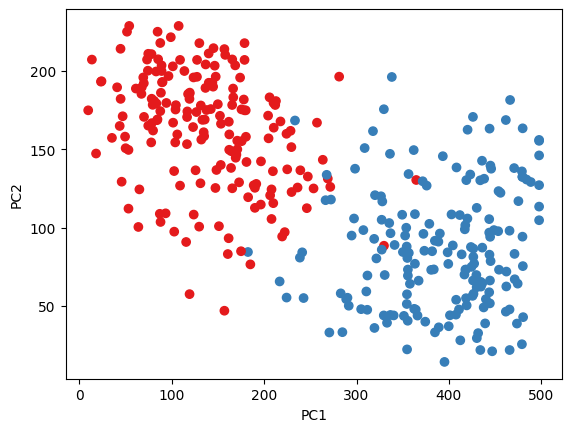

In [9]:
colors = ['#e41a1c', '#377eb8']
labels = np.empty(len(y_all), dtype = int)
labels[y_all == 9] = 1
labels[y_all == 3] = 0

plt.scatter(features.T[0], features.T[1], color=np.array(colors)[labels])
plt.xlabel("PC1")
plt.ylabel("PC2")

### 2.3 Decision rule

In [10]:
training_features = features2d(X_train)
test_features = features2d(X_test)
training_labels = y_train

In [11]:
def nearest_mean(training_features, training_labels, test_features):
    
    mean_3 = sum(training_features[training_labels == 3]) / len(training_features[training_labels == 3])
    mean_9 = sum(training_features[training_labels == 9]) / len(training_features[training_labels == 9])
    
    dis_3 = np.linalg.norm(mean_3 - test_features, axis = 1)
    dis_9 = np.linalg.norm(mean_9 - test_features, axis = 1)
    
    d = dis_3 - dis_9
    
    label = np.empty(len(d), dtype = int)
    
    label[d < 0] = 3
    label[d > 0] = 9
    
    return label, mean_3, mean_9

In [12]:
predicted_labels, mean_3, mean_9 = nearest_mean(training_features, y_train, test_features)

In [13]:
error = abs(100*(sum(y_test == predicted_labels)-len(y_test))/len(y_test))
print("The classifier misclassified %f %% of the data" % round(error,2))

The classifier misclassified 2.740000 % of the data


### 2.4 Visualize the decision regions

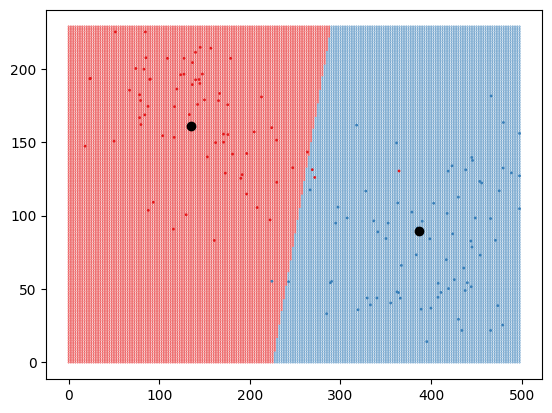

In [14]:
fig, ax = plt.subplots()

y = np.linspace(0,max(features.T[1]),200)
for i in range(0, len(y)):
    grid = np.array([np.linspace(0,max(features.T[0]),200), np.ones(200)*y[i]])
    grid_labels, mean_3, mean_9 = nearest_mean(training_features, training_labels, grid.T)
    grid_labels[grid_labels == 9] = 1
    grid_labels[grid_labels == 3] = 0
    ax.scatter(grid[0], grid[1], color = np.array(colors)[grid_labels], s = 0.1)

predicted_labels_c = y_test
predicted_labels_c[predicted_labels_c == 9] = 1
predicted_labels_c[predicted_labels_c == 3] = 0
    
ax.scatter(test_features.T[0], test_features.T[1], color=np.array(colors)[y_test], s = 1)
ax.scatter(mean_3[0], mean_3[1], c = 'black')
ax.scatter(mean_9[0], mean_9[1], c = 'black')

## 3 LDA
### 3.1 Implement LDA training

In [125]:
tf = training_features
tl = training_labels

def fit_lda(tf, tl):
    D = np.shape(tf)[1]
    mu = np.zeros((2,D))
    
    for i in range(0,D):
        mu[0, i] = np.mean(tf[tl==3].T[i])
        mu[1, i] = np.mean(tf[tl==9].T[i])
    
    covmat = 1/len(tf) * (len(tf[tl==3]) * np.cov(tf[tl==3].T) + len(tf[tl==9]) * np.cov(tf[tl==9].T))
    
    p = np.zeros((2,1))
    p[1] = 
    
    return mu, covmat, p
    
x = fit_lda(training_features, training_labels)

In [124]:
x

(array([[134.57117117, 160.79369369],
        [386.61981132,  89.83301887]]),
 array([[4363.71150087, -373.93852048],
        [-373.93852048, 1501.88284605]]),
 array([[0., 0.]]))

In [115]:
np.cov(tf[tl==3].T) + np.cov(tf[tl==9].T)

array([[8744.97954434, -728.42942392],
       [-728.42942392, 3004.25757353]])

In [116]:
tf.shape

(217, 2)